# ELO: Probey McProbeface

Looking at the lower regions of the [leaderboard][1] for the [Elo Merchant Category Recommendation][2] competition, a cluster of users is very apparent. All with the same score: they all moved about 83 spots down, all made 25 submissions (0 after the deadline) and all have their last submission on the same day (16th Feb 2019).

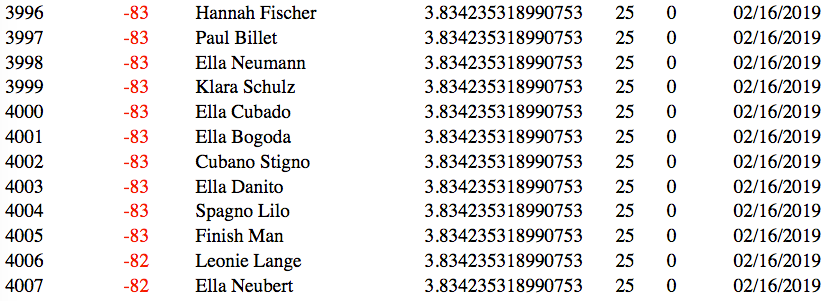

This looks very much like systematic leaderboard probing, with no attempt to hide this behaviour, for example by using a top kernel submission with a better score, they would blend into the regular crowd and be less conspicuous.

Five are named "Ella" and there are further regularities hiding in the data...

This notebook uses the [Meta Kaggle][3] dataset to pull on this thread and finds at least 56 teams **still** on the leaderboard that only made *probing* submissions.

[1]: https://www.kaggle.com/c/elo-merchant-category-recommendation/leaderboard
[2]: https://www.kaggle.com/c/elo-merchant-category-recommendation
[3]: https://www.kaggle.com/kaggle/meta-kaggle


In [1]:
%matplotlib inline
import gc, os, sys, time
import pandas as pd, numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import HTML, Image, display

HOST = 'https://www.kaggle.com'
SLUG = 'elo-merchant-category-recommendation'
FIGSIZE = (9,9)

MK  = Path(f'../input/meta-kaggle')
ELO = Path(f'../input/{SLUG}')

def read_csv_filtered(csv, col, values, **kwargs):
    dfs = [df.loc[df[col].isin(values)]
           for df in pd.read_csv(csv, chunksize=50000, low_memory=False, **kwargs)]
    return pd.concat(dfs, axis=0)

comp = read_csv_filtered(MK / 'Competitions.csv', 'Slug', {SLUG}).set_index('Id')

In [2]:
comp[[
    'Title', 'Slug', 'Subtitle', 'DeadlineDate', 'EvaluationAlgorithmName',
    'MaxDailySubmissions', 'LeaderboardPercentage', 'TotalTeams',
    'TotalCompetitors', 'TotalSubmissions'
]].T

# Leaderboard Probing

Leaderboard probing was very prominent in the [Mercedes-Benz Greener Manufacturing competition][1]. See that thread for an introduction.

Also:

[How to get the exact y-values of all data points used for the computation of the public leaderboard score in the ”Mercedes-Benz Greener Manufacturing” competition on Kaggle][2].

So, why probe?

The ELO competition used the RMSE metric, with the important detail that about 1% of the training targets were severe outliers of -33.219281, very large compared to the overall standard deviation of just 3.850500.

<!--
A zero bias estimate on the training set, i.e. just the mean, will give an RMSE of 3.850500. Every outlier predicted correctly can reduce the squared error sum by 33^2 (1089), when divided by the number of rows (200k in training) this comes out as 1089/200000 = 0.005445, when square rooted by the metric 0.0738, a leap in score. No outlier could be predicted that well but by focussing on reducing outlier loss improvements could be made.
-->

The winning solutions in this competition made heavy use of outlier detection, i.e. classification models to predict the probability a row is an outlier. Feature selection techniques will then select different feature sets based on classifier loss functions. The final predictions of winning teams were based on RMSE based regression models and classification models combined. Focussing on outlier loss and inlier loss separately lead to better predictions.

Probing allows gathering extra target values from the public portion of the test set. Public LB labels are useless on their own for final standings. If they were indeed mined by one person/entity they would only be useful for **building a better outlier classifier**.


[1]: https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/discussion/35271
[2]: https://crowdstats.eu/

In [3]:
train = pd.read_csv(ELO / 'train.csv')
train.shape

In [4]:
test = pd.read_csv(ELO / 'test.csv')
test.shape

Clearly visible outliers:

In [5]:
train.target.plot.hist(bins=100)

The raw stats:

In [6]:
train.target.describe()

In [7]:
train.target.value_counts().head()

In [8]:
train.target.value_counts(normalize=True).head()

In [9]:
pOutlier = 0.010930

# Probing Demo

For ELO, even though the public LB showed only 3 decimal places, that is enough to get feedback probing one line at a time. (Better  schemes are possible but I will stick to one line per submission here.)

Below I mock up a private LB and probing system and show the resulting submission scores. Remember only the public scores are available before the deadline. In my demo, a single submission predicts zeros, with **one row** predicting -33, the outlier value.


In [10]:
public_fraction = comp.LeaderboardPercentage.values[0] / 100
public_fraction

In [11]:
ntest = test.shape[0]
npublic = int(ntest * public_fraction)
# sample from training set - same size as test set
fake_test = train.target.sample(n=ntest, random_state=42).to_frame('target')
fake_test = fake_test.reset_index(drop=True)
fake_test['isprivate'] = 1
fake_test.loc[0:npublic, 'isprivate'] = 0
# shuffle, so we can test just probing the first N rows
fake_test = fake_test.sample(frac=1, random_state=42).reset_index(drop=True)

def probe_sub(i):
    preds = np.zeros_like(fake_test.target)
    preds[i] = -33   # set one prediction to the outlier value
    # compute squared error per row
    tmp = fake_test.assign(err=(fake_test.target - preds) ** 2)
    return list(tmp.groupby('isprivate').err.mean() ** .5) + [
        tmp.target.values[i],
        tmp.isprivate.values[i]
    ]

# do 1000 probing submissions - is this unrealistic? Spoiler alert: NO!
cols = ['public', 'private', 'true_target', 'is_private']
demo_probes = pd.DataFrame([probe_sub(i) for i in range(1000)], columns=cols)
# save in case you want a closer look: remember only 3dp were shown
demo_probes.to_csv('demo_probes.csv', index=False)

This is how submissions scores look.

For all probed lines that are in the private LB set, the public score received will be constant (red points). Those submissions are useless.

In [12]:
demo_probes.plot.scatter('public',
                         'private',
                         c=np.where(demo_probes.is_private, 'red', 'blue'),
                         figsize=FIGSIZE,
                         alpha=0.4)

However, when a probe hits upon an outlier, the public score significantly drops. Now the outliers are in red, and it is clear you can detect them (on the public LB axis) with 3 dp scores: 3.858 versus around 3.866, with a large, reliable margin inbetween.

In [13]:
demo_probes.plot.scatter('public',
                         'private',
                         c=np.where(demo_probes.true_target<-20, 'red', 'blue'),
                         figsize=FIGSIZE,
                         alpha=0.4)

Here are the figures: note that 1000 naive probes get us only FOUR public outliers!!! (true_target==-33.219 and is_private=0).

This is as expected. The public LB is only 30% of the data: we only get public LB feedback 30% of the time, and of those times an outlier is about 1% likely, so 3 in 1000 is average.

However, if you use out of fold predictions of outliers to guide which rows you probe, the hit rate can probably be improved a lot.

In [14]:
(1000 * public_fraction) * pOutlier

In [15]:
demo_probes.round(3).sort_values(['is_private', 'true_target']).query('true_target<-20')

# Meta Kaggle: Read ELO Teams and Submissions

Now inspect all the teams and the submissions they made in the ELO competition.


In [16]:
COMP_ID = comp.index[0]
COMP_ID

In [17]:
teams = read_csv_filtered(MK / 'Teams.csv', 'CompetitionId', {COMP_ID}).set_index('Id')
teams.shape

In [18]:
tm = read_csv_filtered(MK / 'TeamMemberships.csv', 'TeamId', teams.index).set_index('Id')
tm.shape

In [19]:
subs = read_csv_filtered(MK / 'Submissions.csv', 'TeamId', teams.index)
subs.shape

Post deadline submissions are obviously irrelevant! (Note this drops over 10k submissions - impressive! It's good that people go on working and improving their solutions after the competition has finished.)

In [20]:
subs = subs.query('not IsAfterDeadline').drop('IsAfterDeadline', axis=1)
subs = subs.set_index('Id').sort_index().copy()
subs.shape

Quick plot for curiosity - public &amp; private scores very correlated. The competition is all taking place in that narrow corridor. Only the private score matters at the end.

In [21]:
subs.query('PublicScoreFullPrecision<5 and PrivateScoreFullPrecision<5').plot.scatter(
    'PublicScoreFullPrecision',
    'PrivateScoreFullPrecision',
    figsize=FIGSIZE,
    alpha=0.4)

Read all the users that took part.

In [22]:
users = read_csv_filtered(MK / 'Users.csv', 'Id', tm.UserId).set_index('Id')
users.shape

For convenience add user names and team names to all submissions.

In [23]:
subs['UserName'] = subs.SubmittedUserId.map(users.UserName)
subs['TeamName'] = subs.TeamId.map(teams.TeamName)

In [24]:
SUBS_SHOW = [
    'SubmittedUserId', 'TeamId', 'SubmissionDate', 'PublicScoreFullPrecision',
    'PrivateScoreFullPrecision', 'UserName', 'TeamName'
]

Start off by inspecting **ellaneumann**... Five subs a day, all with uncompetitive probey-looking scores.

In [25]:
subs.query('UserName=="ellaneumann"')[SUBS_SHOW]

Better to use a plot - oh - that looks familiar!!!

In [26]:
subs.query('UserName=="ellaneumann"').plot.scatter('PublicScoreFullPrecision', 'PrivateScoreFullPrecision')

Try another - BAM! HIT!

In [27]:
subs.query('UserName=="bogodaellaneumann"').plot.scatter('PublicScoreFullPrecision', 'PrivateScoreFullPrecision')

And another - BINGO!

In [28]:
subs.query('UserName=="cubadoellaneumann"').plot.scatter('PublicScoreFullPrecision', 'PrivateScoreFullPrecision')

Someone is getting lazy with the username generation now - looks like all these subs by all these users are probes :/

In [29]:
subs.query('UserName=="user1ellaneumann"').plot.scatter('PublicScoreFullPrecision', 'PrivateScoreFullPrecision')

Quick check - what are the most common public/private scores? These likely correspond to predicting zero for that subset. (If so, they are also the standard deviation of the target in public/private test.)

In [30]:
subs.PublicScoreFullPrecision.value_counts().head()

In [31]:
subs.PrivateScoreFullPrecision.value_counts().head()

Let's assume one bad actor is using multiple accounts and using ONE probing mechanism for all. What is the simplest thing that works here? Count the appearances of the FULL precision scores, amongst ALL submissions for the competition.

In [32]:
subs['count_pub'] = subs.PublicScoreFullPrecision.map(subs.PublicScoreFullPrecision.value_counts())
subs['count_prv'] = subs.PrivateScoreFullPrecision.map(subs.PrivateScoreFullPrecision.value_counts())

In [33]:
SUBS_SHOW = [
    'TeamId', 'SubmissionDate', 'PublicScoreFullPrecision',
    'PrivateScoreFullPrecision', 'UserName', 'count_pub', 'count_prv'
]

So the one thing true of all **ellaneumann**'s subs is they have a public score seen 1343 times in total, or a private score seen 900 times in total, **but never both**. This depends on whether the row probed is public or private. (We could use full precision float64 score values themselves but comparing floats directly is trickier. Counts work ok.)

In [34]:
subs.query('UserName=="ellaneumann"')[SUBS_SHOW]

Mark all submissions that match the criteria - there are **1053 - WOW**

In [35]:
subs['IsProbe'] = (((subs.count_pub == 1343) & (subs.count_prv != 900)) |
                   ((subs.count_pub != 1343) & (subs.count_prv == 900)))
subs['IsProbe'].sum()

# IsProbe Stats

Make stats on probing submission per team.

In [36]:
stats = subs.groupby('TeamId').IsProbe.agg(['count','sum','mean'])
stats.columns = ['count_subs', 'sum_probes', 'mean_probes']
stats.insert(0, 'PrivateLeaderboardRank', stats.index.map(teams.PrivateLeaderboardRank))
stats.insert(0, 'PublicLeaderboardRank', stats.index.map(teams.PublicLeaderboardRank))
stats.insert(0, 'LeaderUserName', teams.loc[stats.index].TeamLeaderId.map(users.UserName))
stats.insert(0, 'TeamName', stats.index.map(teams.TeamName))

It's usual that sum and mean of probing subs per team are 0. Good. Most teams don't probe.

In [37]:
stats.describe().T

Some random teams: sum and mean of probing submissions is 0 - none of these teams probed.

In [38]:
stats.sample(n=15, random_state=42)

So which teams made **only** probing submissions?

In [39]:
prober_stats = stats.query('mean_probes==1')
prober_stats.shape

Oooh err... 56 of them. The cluster that is visible in the screenshot at the top is all here, along with many more :-/

Bonus "evidence": all but one are multiples of 5 submissions. The limit is 5 submissions per day.

This table is indexed/sorted by TeamId &rarr; same as time. Regularities in the **TeamName** are obvious.

In [40]:
prober_stats

Mark subs by teams that ONLY probed.

In [41]:
subs['PureProbeTeam'] = subs.TeamId.isin(prober_stats.index)
subs['PureProbeTeam'].sum()

In [42]:
subs.to_csv('elo_submissions.csv')

What about teams that did SOME probe submissions matching this big block of pure probers?

Two at the end "Nika Zhidkonozhkina" and "Kim Pem" have many probe submissions. But that does not prove they also created shell accounts.

It's a fairly small set of teams. I don't want to accuse any of these; some could be coincidences. Meta Kaggle does not give us the evidence to say. Submission timing: something may be possible? (If you can think of some extra test to do here please comment!)

One note: there is a [Shakeup incoming!][1] thread where [raddar][2] says:

    p.s. we haven't focused on overrides for a long time now

    There is couple overrides I was able to get during my testing phase early in the competition:
    C_ID_b789a1772c, C_ID_944c62886f

But his team is not listed here - indicating he was using a different probing technique? Perhaps using the mean training value instead of zero. Or probably something smarter that gets more targets at once 8-)

[1]: https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/81657
[2]: https://www.kaggle.com/raddar

In [43]:
stats.query('mean_probes>0 and mean_probes<1').sort_values('mean_probes')

Look at user IDs of members of pure-Probey-McProbeface teams.

In [44]:
probe_members = tm.loc[tm.TeamId.isin(prober_stats.index)]
probe_members.shape

In [45]:
probe_members.head()

Look them up in the users table - notice the **RegisterDate**.

There are https link in the table - try some! Nearly all are **"Joined a year ago · last seen a year ago"**.

Note how "neumann", "schulz", "hofmann" are created early (lower user IDs), then repeated later, multiple times in streaks! Are these famous names? Is there some cultural link I am missing?

Also: gaps in the index (Id = UserId) are quite low. We don't see signup time but could approximate it from Ids. Perhaps account creation is too easy?

In [46]:
df = users.loc[probe_members.UserId]
df.assign(UserName=df.apply(lambda r: f'<a href="https://www.kaggle.com/{r.UserName}">{r.UserName}</a>', 1)).sort_index().style

Six day span - they took 13th Feb off?

In [47]:
users.loc[probe_members.UserId].RegisterDate.value_counts().sort_index()

Plot all probe subs together... Looks like in their scheme - anything under 3.95 public indicated an outlier.

In [48]:
subs.query('PureProbeTeam').plot.scatter('PublicScoreFullPrecision',
                                         'PrivateScoreFullPrecision',
                                         title='All Probe Submissions',
                                         alpha=0.2,
                                         figsize=FIGSIZE)

And so, it looks like they mined **54** public test set outliers with 794 probes. (54 of 794 is about 7% hit rate: way better than random guessing, so they were smart enough to target likely rows.)

In [49]:
subs.query('PureProbeTeam').shape

In [50]:
subs.query('PureProbeTeam and (PublicScoreFullPrecision<3.95)').shape

In [51]:
54 / 794

Lump all these probe submission into one (worst case scenario is it is one entity), between them **90** outliers from **1053** probes for **8.5%** - better rate! Better initial outlier predictions for guiding which rows to probe?!

In [52]:
subs.query('IsProbe').shape

In [53]:
subs.query('IsProbe and (PublicScoreFullPrecision<3.95)').shape

In [54]:
90 / 1053

Look at IDs of submissions made by the 56 McProbeface teams - submission ID appears to be a good proxy for time.

In [55]:
subs.reset_index().groupby('PureProbeTeam').Id.agg(['min','max', np.ptp])

A really narrow band of time towards end of competition:

In [56]:
subs.PureProbeTeam.astype(int).plot()

Focus on just that time window.

In [57]:
window = subs.reset_index().query('Id>=10060463 and Id<=10108434')
window[['IsProbe', 'PureProbeTeam']] *= 1
window.shape

All subs in that time with probe-only teams in red; probes are in short, concentrated streaks, suggesting one person working through all these accounts.

In [58]:
window.plot.scatter('Id',
                    'IsProbe',
                    c=np.where(window.PureProbeTeam, 'red', 'blue'),
                    figsize=(15, 2),
                    title='Subs Over Time - McProbeface teams in red',
                    alpha=0.4)

Only probe subs - McProbeface teams in red. Nothing leaps out here - need a better plot to see if the semi-probing teams are connected in any way with the McProbeface teams.

In [59]:
window = window.query('IsProbe>0')
window.plot.scatter('Id',
                    'PureProbeTeam',
                    c=np.where(window.PureProbeTeam, 'red', 'blue'),
                    figsize=(15, 2),
                    title='Probe Subs Over Time - McProbeface teams in red',
                    alpha=0.4)

In [60]:
comp.DeadlineDate

Here's a 2D grid - a new batch of McProbefaces was minted on 02/16/2019, did 5 subs each, along with the old ones, then the whole thing stops!

In [61]:
grid = subs.query('PureProbeTeam>0').groupby(['TeamId', 'SubmissionDate']).size().unstack().fillna('')
grid.insert(0, 'TeamName', grid.index.map(teams.TeamName))
grid

Find the *range* of submission IDs each day for these users. Submission ID is GLOBAL - shared across ALL competitions. All the ranges are really small, fast bursts of submissions.

In [62]:
gb = subs.query('PureProbeTeam>0').reset_index().groupby(['TeamId', 'SubmissionDate'])
grid = (gb.Id.max() - gb.Id.min()).unstack().fillna('')
grid.insert(0, 'TeamName', grid.index.map(teams.TeamName))
grid

Random sample of 20 users who made 5 subs for the last day shown above. Leaving TeamName out to keep them anon-ish. Gap in sub IDs usually bigger.

In [63]:
gb = subs.query('PureProbeTeam==0 and SubmissionDate=="02/16/2019"').reset_index().groupby('TeamId')
grid = gb.Id.agg(['count', 'min', 'max']).query('count==5').sample(n=20, random_state=42)
grid['IdRange'] = grid['max'] - grid['min']
grid

# Shell Account Stats

What if this is all some kind of odd coincidence? What else can we tell about the accounts? Let's look at how many other tables the UserIds appear in. This summarizes all their activity on the site. Do these shell accounts vote for kernels? Vote for forum posts? Write kernels? *Follow* others?

In [64]:
# Columns in other tables that represent user activity on the site
USER_STATS = [
    ('Datasets', 'CreatorUserId'),
    ('DatasetVersions', 'CreatorUserId'),
    ('DatasetVotes', 'UserId'),
    ('ForumMessages', 'PostUserId'),
    ('ForumMessageVotes', 'FromUserId'),
    ('ForumMessageVotes', 'ToUserId'),
    ('Kernels', 'AuthorUserId'),
    ('KernelVersions', 'AuthorUserId'),
    ('KernelVotes', 'UserId'),
    ('UserFollowers', 'UserId'),
    ('UserFollowers', 'FollowingUserId')
]

def add_stats(dst, csv, col):
    df = read_csv_filtered(MK / (csv + '.csv'), col, users.index, usecols=[col])
    users[dst] = users.index.map(df[col].value_counts())
    print(dst, csv, col, users[dst].count())
    
for i, (csv, col) in enumerate(USER_STATS, 1):
    add_stats(f'C{i}', csv, col)

users['ActivitySums'] = (users[users.columns[users.columns.str.startswith('C')]]>0).sum(1)

Nope. Big fat ZERO. These are clearly not real users. They don't vote for anything, write any kernels, post any comments, create datasets, follow users and they are not followed by anyone either.

In [65]:
users.loc[probe_members.UserId].describe().T

A random sample of the same number of users from the whole pool that took part in ELO shows it is hard to find a group with no activity...

In [66]:
users.sample(n=56, random_state=42).describe().T

For comparison - this is how activity counts look for users in the top 10 teams - heavy *Kagglers*...

This is just to show - Kaggle would really miss these users. The shell accounts with 0 activity? Would not be missed at all ;)

In [67]:
top10 = teams.query('PrivateLeaderboardRank<=10')
df = users.loc[tm[tm.TeamId.isin(top10.index)].UserId]
df.fillna('').style.bar(subset=['ActivitySums'], vmin=0)


# Conclusions

Probing the leaderboard is not against the rules - enforcing it is unworkable.

However, creating multiple accounts to submit from is most definitely against Kaggle's rules and is the most cited reason for removal from competitions.

We only see half the story here - the real issue is who used these accounts and to what benefit? If the perpetrators were caught and these probe accounts are part of the evidence against them - why are they still there? It suggests Kaggle missed this.

In other words: Kaggle missed this cluster of teams, or noticed it and decided to leave it. Either is bad.


## Who?

It is kind of fascinating that someone went to these lengths to get an unfair advantage. The hit rate of detected outliers suggests they knew enough to guide their probe submissions. But the fact it stopped abruptly 10 days before the deadline suggests to me an amateur/beginner who gave up.

Who has the patience and spare time combination to create 56 shell accounts? It could be automated but I thought at least a phone number is required?

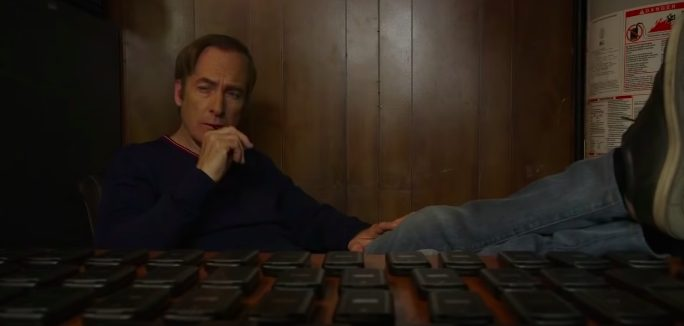

*Go big or go home :)*

[Rob Mulla][1] made a [similar notebook][2] and got a blizzard of downvotes in return. It *could* be the same user as featured there. Fake accounts are clearly already linked to him. It's not the same pattern though. Could that guy resist not adding new accounts as followers?

Whoever it is, I am risking 56 downvotes on all my past/future discussion posts if the perp has nothing better to do :P

## Solutions

Seeing probing at this scale hints that it is not solved yet... Here are some ideas.

1. As mentioned by [Triskelion][6] in this [Mercedes thread][4] : [The Ladder: A Reliable Leaderboard for Machine Learning Competitions][5]. (https://arxiv.org/abs/1502.04585) 

2. Even fewer decimals

3. Alternative number bases. E.g. octal: 1 digit gives 1/8ths. 2 digits give 1/64ths. etc. If any crowd can learn non-decimal fractions it should be the Kaggle crowd :)

Or perhaps none of these if Kaggle plan to move entirely to code competitions with hidden test sets.

[1]: https://www.kaggle.com/robikscube
[2]: https://www.kaggle.com/robikscube/identifying-potential-fake-accounts-on-kaggle
[3]: https://www.kaggle.com/jtrotman/meta-kaggle-count-user-activities
[4]: https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/discussion/35566#200252
[5]: https://arxiv.org/abs/1502.04585
[6]: https://www.kaggle.com/triskelion
